In [1]:
!nvidia-smi

Sat Aug 20 09:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/

In [2]:
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c hubmap-organ-segmentation

100% 5.77G/5.78G [01:16<00:00, 81.0MB/s]
100% 5.78G/5.78G [01:16<00:00, 80.8MB/s]


In [4]:
# !mkdir hubmap
!unzip /content/hubmap-organ-segmentation.zip -d hubmap >/dev/null

In [5]:
!pip install pytorch-lightning
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 12.5 MB/s 
     |████████████████████████████████| 419 kB 49.7 MB/s 
     |████████████████████████████████| 5.9 MB 45.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.9 MB/s 
     |████████████████████████████████| 365 kB 49.3 MB/s 
     |████████████████████████████████

In [6]:
%load_ext tensorboard

In [7]:
# from google.colab import output
# output.enable_custom_widget_manager()

## Start code

In [8]:
# !pip install timm

In [9]:
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from timm import create_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import albumentations as albu
import random

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [10]:
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

##  load test data

In [11]:
SEED = 43
BATCH_SIZE = 4

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [13]:
DATA_DIR = './hubmap'
NFOLD = 5
FOLD = 0

WIDTH, HEIGHT = 512,512

# MODEL_NAME = "nvidia/mit-b3"
MODEL_NAME = "nvidia/segformer-b2-finetuned-ade-512-512"
#
# nvidia/segformer-b0-finetuned-ade-512-512
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-ade-512-512
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b4-finetuned-ade-512-512
# nvidia/segformer-b5-finetuned-ade-640-640
# https://huggingface.co/models?other=segformer&sort=downloads&search=nvidia%2Fsegformer+finetuned
#
df = pd.read_csv(DATA_DIR + '/train.csv')

In [14]:
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [15]:
class2idx = dict([(name,i+1) for i, name in enumerate(df.organ.unique())])
class2idx['none'] = 0
idx2class = dict([(class2idx[name], name) for name in class2idx])
class2idx, idx2class

({'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0},
 {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'})

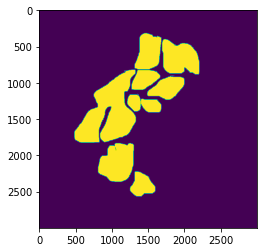

In [16]:
idx = 0
height, width, rle = df['img_height'][idx], df['img_width'][idx], df['rle'][idx]
mask = rle2mask(rle, shape=(height, width))
plt.imshow(mask)

In [17]:
from sklearn.model_selection import StratifiedKFold

df['fold'] = 0

skf = StratifiedKFold(n_splits=5)
for i, index in enumerate(skf.split(df.id, df.organ)):
  train_index, test_index = index
  # print("train_index:", train_index, "test_index:", test_index)
  # df['fold'][test_index] = i
  df.loc[test_index, 'fold'] = i

df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,0
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,4
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,4
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,4
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,4


## Utils

### augumentation

In [18]:
def get_training_augmentation3(p=0.5):
    return albu.Compose([
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=1),
            albu.GridDistortion(p=1),
            albu.IAAPiecewiseAffine(p=1),
        ], p=p),
        albu.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=1),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p)
    ], p=p)


In [19]:
def get_training_augmentation2(p=1.0):
    return albu.Compose([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        albu.OneOf([
            # albu.HueSaturationValue(10,15,10),
            albu.CLAHE(clip_limit=2),
            albu.RandomBrightnessContrast(),            
        ], p=0.3),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
    ], p=p)

def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_grayaug():
    train_transform = [
        albu.ToGray(p=1.0),
    ]
    return albu.Compose(train_transform)

# def get_validation_augmentation():
#     """画像のshapeが32で割り切れるようにPaddingするための関数"""
#     test_transform = [
#         albu.PadIfNeeded(384, 480)
#     ]
#     return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataset

In [20]:
from transformers import SegformerFeatureExtractor

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


# 1. torch.utils.data.Datasetを継承したDataset classを定義
class Dataset(torch.utils.data.Dataset):
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self,
            image_dir, 
            df, # ファイル名一覧
            # classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
            width = 768,
            height = 768,
    ):
        self.image_dir = image_dir
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.width = width
        self.height = height
        self.feature_extractor = SegformerFeatureExtractor(MODEL_NAME , reduce_labels=False, size=(width, height))
    
    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        # データの読み込み
        fname = "{}/{}.tiff".format(self.image_dir,self.df['id'][i])
        # print(fname)
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rle, w, h = self.df['rle'][i], self.df['img_width'][i], self.df['img_height'][i]
        idx = class2idx[self.df['organ'][i]]
        mask = rle2mask(rle, shape = (w, h))
        # print(self.df['organ'][i], idx)

        image = cv2.resize(image, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height)) * idx

        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # return image, mask
        # image = (image/255 - mean)/std
        
        # return img2tensor(image),torch.tensor(mask), idx
        # return image, mask
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    # 4. データセットの長さを返す__len__を作成
    def __len__(self):
        return len(self.df)

torch.Size([3, 512, 512])


tensor([0, 3])

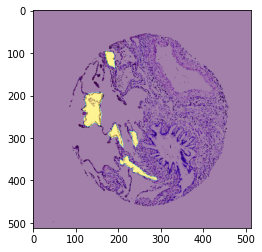

In [21]:
IMAGE_DIR = './hubmap/train_images'
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), width=WIDTH, height=HEIGHT)
input = train_dataset[0]
print(input['pixel_values'].shape)
plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
plt.imshow(input['labels'], alpha=0.5)
input['labels'].unique()

In [22]:
input

{'pixel_values': tensor([[[2.0434, 2.0605, 2.0263,  ..., 2.0434, 2.0605, 2.0263],
         [2.0434, 2.0263, 2.0434,  ..., 2.0605, 2.0605, 2.0605],
         [2.0434, 2.0605, 2.0434,  ..., 2.0777, 2.0605, 2.0434],
         ...,
         [2.0605, 2.0263, 2.0434,  ..., 2.0263, 2.0777, 2.0434],
         [2.0434, 2.0434, 2.0263,  ..., 2.0263, 2.0263, 2.0605],
         [2.0605, 2.0263, 2.0434,  ..., 2.0434, 2.0605, 2.0263]],

        [[2.2185, 2.2185, 2.2010,  ..., 2.2185, 2.2360, 2.2185],
         [2.2010, 2.2360, 2.2535,  ..., 2.2535, 2.2185, 2.2185],
         [2.2185, 2.2185, 2.2360,  ..., 2.2360, 2.2185, 2.2185],
         ...,
         [2.2360, 2.2010, 2.2360,  ..., 2.1835, 2.2185, 2.2360],
         [2.2185, 2.2185, 2.2185,  ..., 2.2360, 2.2360, 2.2360],
         [2.2185, 2.2185, 2.2185,  ..., 2.1835, 2.2185, 2.2185]],

        [[2.4483, 2.3960, 2.4134,  ..., 2.4134, 2.4308, 2.4134],
         [2.4483, 2.4483, 2.4308,  ..., 2.4483, 2.4483, 2.4134],
         [2.4483, 2.4134, 2.4134,  ..., 2

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:301: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


280
0


0


0


0


0


0


0


0


0


0


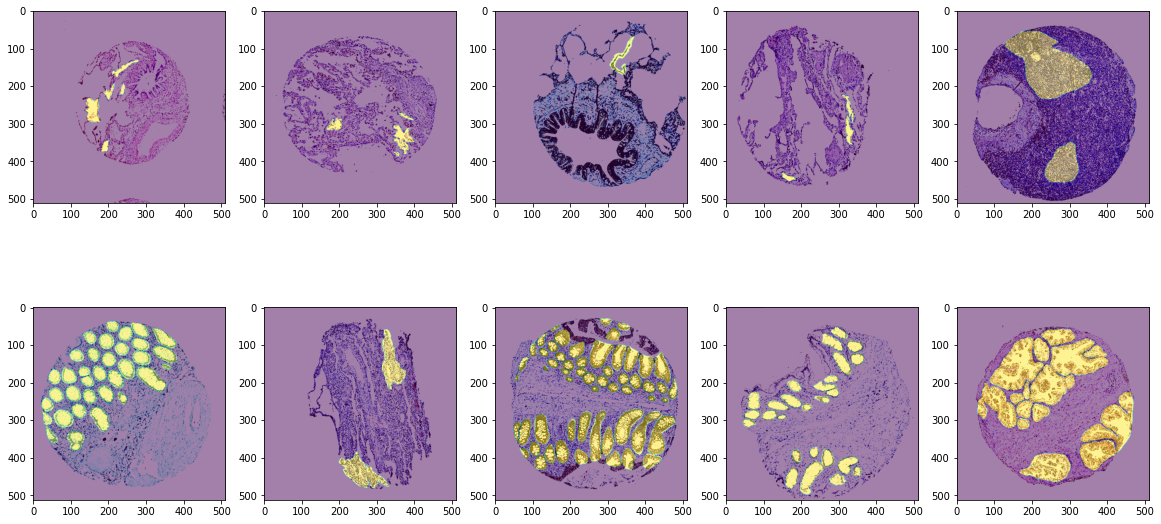

In [23]:
# # # データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != 0].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(), 
                        )

plt.figure(figsize=(20, 10))

print(train_dataset.__len__())
for i in range(10) :
  input = train_dataset[i]
  print(idx)
  plt.subplot(2, 5, i+1);
  plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
  plt.imshow(input['labels'], alpha=0.5)
plt.show()

In [24]:
from torch.utils.data import DataLoader
# CLASSES = ['car']


# データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(p=0.9), 
                        )

valid_dataset = Dataset(
    IMAGE_DIR, df[df['fold'] == FOLD].reset_index(), 
    width=WIDTH, height=HEIGHT,
    augmentation=None, 
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

0


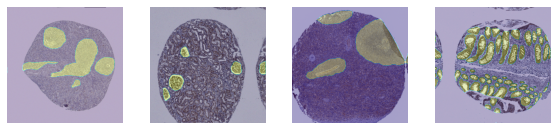

In [25]:
row, col = 8, 8
plt.figure(figsize=(20,20))


for inputs in train_loader:
  print(idx)
  data = inputs['pixel_values']
  mask = inputs['labels']
  for i in range(BATCH_SIZE) :
    plt.subplot(col, row, i+1)
    x = data[i].permute(1,2,0)
    plt.imshow((x-x.min())/(x.max()-x.min()))
    plt.imshow(mask[i], alpha=0.3)
    plt.axis('off')
  # print(data.shape)
  break

# ここまで前処理

In [26]:
from transformers import SegformerForSemanticSegmentation
# define model
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                         num_labels=len(class2idx), 
                                                         id2label=idx2class, 
                                                         label2id=class2idx,
                                                         ignore_mismatched_sizes=True,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([6, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model.load_state_dict(torch.load(model_path))

In [28]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [29]:
test_df = df[df['fold'] == FOLD].reset_index()

def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice

def valid(model2) :
  model2.eval()
  dice = 0.0
  for i in tqdm(range(len(test_df))) :
    id = test_df.id[i]
    fname = "/content/hubmap/train_images/{}.tiff".format(id)
    image = Image.open(fname)
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.cuda()
    organ = test_df.organ[i]
    rle = test_df.rle[i]
    height, width = test_df.img_height[i], test_df.img_width[i]
    idx = class2idx[organ]
    with torch.no_grad():
      outputs = model2(pixel_values=pixel_values)
      upsampled_logits = nn.functional.interpolate(outputs['logits'],
                  # size=image.size[::-1], # (height, width)
                  (height, width),
                  mode='bilinear',
                  align_corners=False)
      mask = upsampled_logits.argmax(dim=1)[0]
      mask[mask != idx] = 0
      mask[mask == idx] = 1

    gt = rle2mask(rle, shape = (height, width))

    dice += dice_coef(mask.cpu().numpy(), gt)
  return dice/len(test_df)

In [30]:
# valid(model)

# TRAIN


In [24]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from fastprogress.fastprogress import  progress_bar as tqdm

from PIL import Image
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))

use_amp = True # ampをオンオフ

Gradient_Accumulation_Step = 7

# define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

model.train()
cur_loss = 0
for epoch in range(100):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   
   model.train()
   optimizer.zero_grad()

   tot_loss = 0.0
   for idx, batch in enumerate(tqdm(train_loader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # print(pixel_values.shape, labels.shape)

        # zero the parameter gradients
        with torch.cuda.amp.autocast(enabled=use_amp):
            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

        tot_loss += loss.detach().cpu().numpy()
        
        scaler.scale(loss).backward()

        if (idx + 1) % Gradient_Accumulation_Step == 0 or idx == len(train_loader) :
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        # optimizer.zero_grad()

        # loss.backward()
        # optimizer.step()

        # evaluate
        # with torch.no_grad():
        #   upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        #   predicted = upsampled_logits.argmax(dim=1)
          
        #   # note that the metric expects predictions + labels as numpy arrays
        #   metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # # let's print loss and metrics every 100 batches
        # if idx % 100 == 0:
        #   metrics = metric.compute(num_labels=len(class2idx), 
        #                            ignore_index=255,
        #                            reduce_labels=False, # we've already reduced the labels before)
        #   )

        #   print("Loss:", loss.item())
        #   print("Mean_iou:", metrics["mean_iou"])
        #   print("Mean accuracy:", metrics["mean_accuracy"])

   print("Loss:", tot_loss/len(train_loader))
   print("valid...")
   dice = valid(model)
   if dice > cur_loss :
     cur_loss = dice
     print("update best dice = ", dice)
     model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
     torch.save(model.state_dict(), model_path)
   else :
     print("epoch dice = ", dice)

Epoch: 0


Loss: 1.603484845161438
valid...


update best dice =  0.30564696032567806
Epoch: 1


Loss: 1.2615528583526612
valid...


epoch dice =  0.2940038637723631
Epoch: 2


Loss: 1.001936881031309
valid...


epoch dice =  0.3004732506517827
Epoch: 3


Loss: 0.7767086105687278
valid...


update best dice =  0.3177407524790345
Epoch: 4


Loss: 0.6520013059888567
valid...


update best dice =  0.34856580571541923
Epoch: 5


Loss: 0.5436123260429927
valid...


update best dice =  0.39446220059780107
Epoch: 6


Loss: 0.4606037723166602
valid...


update best dice =  0.5070694096512354
Epoch: 7


Loss: 0.4080855586699077
valid...


update best dice =  0.6129233339620485
Epoch: 8


Loss: 0.362620119537626
valid...


update best dice =  0.6294766615641201
Epoch: 9


Loss: 0.3179789996572903
valid...


update best dice =  0.6425347504137365
Epoch: 10


Loss: 0.29154748427016397
valid...


update best dice =  0.6623383392105742
Epoch: 11


Loss: 0.26353028650794713
valid...


update best dice =  0.6675637750568448
Epoch: 12


Loss: 0.2534200683236122
valid...


update best dice =  0.6713221620346537
Epoch: 13


Loss: 0.22860202533858162
valid...


update best dice =  0.6795513051424769
Epoch: 14


Loss: 0.21478120791060584
valid...


update best dice =  0.6834958320016585
Epoch: 15


Loss: 0.20271475570542472
valid...


update best dice =  0.6945994711470486
Epoch: 16


Loss: 0.20011014406170163
valid...


update best dice =  0.6947701260936084
Epoch: 17


Loss: 0.19114999387945447
valid...


update best dice =  0.7088294286574153
Epoch: 18


Loss: 0.1815441389169012
valid...


epoch dice =  0.7050336635223063
Epoch: 19


Loss: 0.1721892036497593
valid...


epoch dice =  0.7084711797413278
Epoch: 20


Loss: 0.16322256220238548
valid...


update best dice =  0.7099935022369745
Epoch: 21


Loss: 0.1591157952589648
valid...


update best dice =  0.7168413782708789
Epoch: 22


Loss: 0.15416243257267134
valid...


epoch dice =  0.7116038914951502
Epoch: 23


Loss: 0.14734078156096594
valid...


epoch dice =  0.7098500955360197
Epoch: 24


Loss: 0.15189072191715242
valid...


epoch dice =  0.7092607192389395
Epoch: 25


Loss: 0.1397630791578974
valid...


epoch dice =  0.7134231251329
Epoch: 26


Loss: 0.13889056273869105
valid...


update best dice =  0.7207784142142475
Epoch: 27


Loss: 0.13412239993257183
valid...


update best dice =  0.7226922076707033
Epoch: 28


Loss: 0.13549321070313453
valid...


epoch dice =  0.7150055439516717
Epoch: 29


Loss: 0.1265042383223772
valid...


update best dice =  0.7240792196704556
Epoch: 30


Loss: 0.13008038428212915
valid...


epoch dice =  0.709236102472161
Epoch: 31


Loss: 0.12843077927827834
valid...


update best dice =  0.7271016183624847
Epoch: 32


Loss: 0.1215544025280646
valid...


epoch dice =  0.7232122403331392
Epoch: 33


Loss: 0.1208651634731463
valid...


epoch dice =  0.7238610185176343
Epoch: 34


Loss: 0.11683013891535146
valid...


epoch dice =  0.7221588382351645
Epoch: 35


Loss: 0.11149787423866135
valid...


update best dice =  0.7311911502530599
Epoch: 36


Loss: 0.11193586210055011
valid...


epoch dice =  0.7302137054053643
Epoch: 37


Loss: 0.11087411721902234
valid...


update best dice =  0.7323105612198467
Epoch: 38


Loss: 0.10809269994497299
valid...


update best dice =  0.7336332115052633
Epoch: 39


Loss: 0.10629528234047549
valid...


epoch dice =  0.7321597086911223
Epoch: 40


Loss: 0.1040127303983484
valid...


epoch dice =  0.7329563470398425
Epoch: 41


Loss: 0.10349237152508327
valid...


update best dice =  0.736602267126947
Epoch: 42


Loss: 0.10390923166913646
valid...


update best dice =  0.7432111577135162
Epoch: 43


Loss: 0.0994709450751543
valid...


epoch dice =  0.7358949850612343
Epoch: 44


Loss: 0.10286382106798035
valid...


epoch dice =  0.7355093256432408
Epoch: 45


Loss: 0.09895365195614951
valid...


epoch dice =  0.7400507554558533
Epoch: 46


Loss: 0.09854669884911606
valid...


epoch dice =  0.7413741959123333
Epoch: 47


Loss: 0.09904714865343911
valid...


epoch dice =  0.741992057833401
Epoch: 48


Loss: 0.09177261708038194
valid...


epoch dice =  0.7382407386084728
Epoch: 49


Loss: 0.09182226546108722
valid...


epoch dice =  0.7380170461608567
Epoch: 50


Loss: 0.09151810200086662
valid...


epoch dice =  0.735244146878299
Epoch: 51


Loss: 0.09237727874091693
valid...


epoch dice =  0.7404085930324775
Epoch: 52


Loss: 0.08770913641367639
valid...


epoch dice =  0.7350708029916425
Epoch: 53


Loss: 0.09213931746780872
valid...


update best dice =  0.7522686987050852
Epoch: 54


Loss: 0.09089642555585929
valid...


epoch dice =  0.7499166446848213
Epoch: 55


Loss: 0.08625055365264415
valid...


epoch dice =  0.7359312910079756
Epoch: 56


Loss: 0.08460452748196466
valid...


epoch dice =  0.7371846651681189
Epoch: 57


Loss: 0.08954379883195673
valid...


epoch dice =  0.7434821831090539
Epoch: 58


Loss: 0.08818546911435468
valid...


epoch dice =  0.7419726221173863
Epoch: 59


Loss: 0.08349500192063196
valid...


update best dice =  0.7539972643825769
Epoch: 60


Loss: 0.08147602986012187
valid...


epoch dice =  0.7467746335943264
Epoch: 61


Loss: 0.08103691222412246
valid...


epoch dice =  0.7470834704529623
Epoch: 62


Loss: 0.0770353730235781
valid...


update best dice =  0.7573700046403274
Epoch: 63


Loss: 0.07898245978036098
valid...


update best dice =  0.7578647036972662
Epoch: 64


Loss: 0.08325037801904338
valid...


update best dice =  0.7633643381857018
Epoch: 65


Loss: 0.08048855883202383
valid...


update best dice =  0.7686316267796477
Epoch: 66


Loss: 0.07841102597968919
valid...


epoch dice =  0.7503465097689529
Epoch: 67


Loss: 0.07824739760586194
valid...


epoch dice =  0.7482314616795069
Epoch: 68


Loss: 0.0765105421787926
valid...


epoch dice =  0.7528541473084674
Epoch: 69


Loss: 0.07854080641908305
valid...


epoch dice =  0.7636821256883627
Epoch: 70


Loss: 0.0755846632378442
valid...


epoch dice =  0.764679556469366
Epoch: 71


Loss: 0.07694544039134468
valid...


epoch dice =  0.7511799152597244
Epoch: 72


Loss: 0.07617308446871383
valid...


epoch dice =  0.7586019144491126
Epoch: 73


Loss: 0.07353149607245411
valid...


epoch dice =  0.7667091744610899
Epoch: 74


Loss: 0.07121640701911279
valid...


epoch dice =  0.7561213233377904
Epoch: 75


Loss: 0.07162864104445492
valid...


epoch dice =  0.7606961009073566
Epoch: 76


Loss: 0.07734209905777659
valid...


epoch dice =  0.7637116570404575
Epoch: 77


Loss: 0.07645281074302537
valid...


epoch dice =  0.759428950657953
Epoch: 78


Loss: 0.07294934447854758
valid...


epoch dice =  0.7519694706616398
Epoch: 79


Loss: 0.07229966771389756
valid...


epoch dice =  0.7551723754205502
Epoch: 80


Loss: 0.07594825367310218
valid...


epoch dice =  0.7314875010173617
Epoch: 81


Loss: 0.07757407873868942
valid...


epoch dice =  0.7667715507579024
Epoch: 82


Loss: 0.07604217803371804
valid...


epoch dice =  0.7556562662952461
Epoch: 83


Loss: 0.07437548174389771
valid...


epoch dice =  0.767858552254315
Epoch: 84


Loss: 0.06953041228864874
valid...


epoch dice =  0.753395754159155
Epoch: 85


Loss: 0.06998136173933744
valid...


epoch dice =  0.763526556054192
Epoch: 86


Loss: 0.07313914559781551
valid...


epoch dice =  0.7591453379021539
Epoch: 87


Loss: 0.07058609489883695
valid...


update best dice =  0.7693474516197167
Epoch: 88


Loss: 0.06712073050439357
valid...


epoch dice =  0.7642224319455515
Epoch: 89


Loss: 0.07040608088885035
valid...


epoch dice =  0.7578896278452704
Epoch: 90


Loss: 0.06832174640148878
valid...


update best dice =  0.7765691041520607
Epoch: 91


Loss: 0.06866057674799647
valid...


epoch dice =  0.7659821571923963
Epoch: 92


Loss: 0.06684161185153893
valid...


epoch dice =  0.7555597077318823
Epoch: 93


Loss: 0.06495589643184628
valid...


epoch dice =  0.7670192692761109
Epoch: 94


Loss: 0.06742494295218161
valid...


epoch dice =  0.7512935695673538
Epoch: 95


Loss: 0.06763758656701871
valid...


epoch dice =  0.7562909634512356
Epoch: 96


Loss: 0.06690234592450517
valid...


epoch dice =  0.7492222574455302
Epoch: 97


Loss: 0.0639300661427634
valid...


epoch dice =  0.7701607290436755
Epoch: 98


Loss: 0.0668154241251094
valid...


epoch dice =  0.7573976995499977
Epoch: 99


Loss: 0.06431482822767326
valid...


epoch dice =  0.7635411236813945


In [31]:
model_path = '/content/drive/MyDrive/datas/HuBMAP/last.pth'
torch.save(model.state_dict(), model_path)

In [26]:
# from transformers import SegformerForSemanticSegmentation
# # define model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )

In [27]:
# model2 = SegformerForSemanticSegmentation(model.config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model2.load_state_dict(torch.load(model_path))
# model2 = model2.cuda()

In [28]:
# from PIL import Image
# image = Image.open('/content/hubmap/train_images/10044.tiff')
# plt.imshow(image)

In [29]:
# from transformers import SegformerFeatureExtractor
# feature_extractor = SegformerFeatureExtractor(reduce_labels=False)

# encoding = feature_extractor(image, return_tensors="pt")
# pixel_values = encoding.pixel_values.cuda()
# print(pixel_values.shape)

In [30]:
# # forward pass
# outputs = model2(pixel_values=pixel_values)

In [31]:
# logits = outputs.logits.cpu()
# print(logits.shape)

In [32]:
# def ade_palette():
#     """ADE20K palette that maps each class to RGB values."""
#     return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
#             [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255]]

In [33]:
# from torch import nn
# import numpy as np
# import matplotlib.pyplot as plt

# # First, rescale logits to original image size
# upsampled_logits = nn.functional.interpolate(logits,
#                 size=image.size[::-1], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)

# # Second, apply argmax on the class dimension
# seg = upsampled_logits.argmax(dim=1)[0]
# color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
# palette = np.array(ade_palette())
# for label, color in enumerate(palette):
#     color_seg[seg == label, :] = color
# # Convert to BGR
# color_seg = color_seg[..., ::-1]

# # Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

# inference

In [32]:
def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice


In [33]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerModel, SegformerConfig

# define model
# model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )


config = SegformerConfig.from_pretrained(MODEL_NAME,
                        num_labels=len(class2idx), 
                        id2label=idx2class, 
                        label2id=class2idx,
                        ignore_mismatched_sizes=True,
)

model2 = SegformerForSemanticSegmentation(config)
model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
model2.load_state_dict(torch.load(model_path))
model2 = model2.cuda()

In [34]:
from PIL import Image
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))

# print(pixel_values.shape)
# image = Image.open('/content/hubmap/train_images/10651.tiff')
# plt.imshow(image)

model2.eval()
dice = 0.0

test_df = df[df['fold'] == FOLD].reset_index()
for i in range(len(test_df)) :
  id = test_df.id[i]
  fname = "/content/hubmap/train_images/{}.tiff".format(id)
  image = Image.open(fname)
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.cuda()
  organ = test_df.organ[i]
  rle = test_df.rle[i]
  height, width = test_df.img_height[i], test_df.img_width[i]
  idx = class2idx[organ]
  with torch.no_grad():
    outputs = model2(pixel_values=pixel_values)
    upsampled_logits = nn.functional.interpolate(outputs['logits'],
                # size=image.size[::-1], # (height, width)
                (height, width),
                mode='bilinear',
                align_corners=False)
    mask = upsampled_logits.argmax(dim=1)[0]
    mask[mask != idx] = 0
    mask[mask == idx] = 1

  gt = rle2mask(rle, shape = (height, width))
  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.imshow(mask.cpu().numpy(), alpha=0.3)
  plt.title("{}-{}-{},{}".format(id, organ, width, height))
  plt.subplot(1, 2, 2)
  plt.imshow(image)
  plt.imshow(gt, alpha=0.3)
  plt.show()

  dice += dice_coef(mask.cpu().numpy(), gt)
  print(dice_coef(mask.cpu().numpy(), gt), dice/(i+1))

print("DICE = ", dice/len(test_df))

Output hidden; open in https://colab.research.google.com to view.

In [35]:
len(test_df)

71

In [38]:
# First, rescale logits to original image size


In [39]:
# model = model.cuda()

# for batch, idx in train_loader:
#   pixel_values = batch["pixel_values"].cuda()
#   labels = batch["labels"].cuda()
#   outputs = model(pixel_values=pixel_values, labels=labels)
#   print(outputs.loss, outputs.logits)
#   break

## U-net model with timm

In [40]:
# """ A simple U-Net w/ timm backbone encoder
# Based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
# Hacked together by Ross Wightman
# """
# class Unet(nn.Module):
#     """Unet is a fully convolution neural network for image semantic segmentation
#     Args:
#         encoder_name: name of classification model (without last dense layers) used as feature
#             extractor to build segmentation model.
#         encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
#         decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
#         decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
#             is used.
#         num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
#         center: if ``True`` add ``Conv2dReLU`` block on encoder head
#     NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
#     """

#     def __init__(
#             self,
#             backbone='resnet50',
#             backbone_kwargs=None,
#             backbone_indices=None,
#             decoder_use_batchnorm=True,
#             decoder_channels=(256, 128, 64, 32, 16),
#             in_chans=1,
#             num_classes=5,
#             center=False,
#             norm_layer=nn.BatchNorm2d,
#     ):
#         super().__init__()
#         backbone_kwargs = backbone_kwargs or {}
#         # NOTE some models need different backbone indices specified based on the alignment of features
#         # and some models won't have a full enough range of feature strides to work properly.
#         encoder = create_model(
#             backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
#             pretrained=True, **backbone_kwargs)
#         encoder_channels = encoder.feature_info.channels()[::-1]
#         self.encoder = encoder

#         if not decoder_use_batchnorm:
#             norm_layer = None
#         self.decoder = UnetDecoder(
#             encoder_channels=encoder_channels,
#             decoder_channels=decoder_channels,
#             final_channels=num_classes,
#             norm_layer=norm_layer,
#             center=center,
#         )

#     def forward(self, x: torch.Tensor):
#         x = self.encoder(x)
#         x.reverse()  # torchscript doesn't work with [::-1]
#         x = self.decoder(x)
#         return x


# class Conv2dBnAct(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, padding=0,
#                  stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
#         self.bn = norm_layer(out_channels)
#         self.act = act_layer(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.act(x)
#         return x


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
#         super().__init__()
#         conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
#         self.scale_factor = scale_factor
#         if norm_layer is None:
#             self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
#             self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
#         else:
#             self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
#             self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

#     def forward(self, x, skip: Optional[torch.Tensor] = None):
#         if self.scale_factor != 1.0:
#             x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
#         if skip is not None:
#             x = torch.cat([x, skip], dim=1)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         return x


# class UnetDecoder(nn.Module):

#     def __init__(
#             self,
#             encoder_channels,
#             decoder_channels=(256, 128, 64, 32, 16),
#             final_channels=1,
#             norm_layer=nn.BatchNorm2d,
#             center=False,
#     ):
#         super().__init__()

#         if center:
#             channels = encoder_channels[0]
#             self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
#         else:
#             self.center = nn.Identity()

#         in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
#             [encoder_channels[0]] + list(decoder_channels[:-1]),
#             list(encoder_channels[1:]) + [0])]
#         out_channels = decoder_channels

#         self.blocks = nn.ModuleList()
#         for in_chs, out_chs in zip(in_channels, out_channels):
#             self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
#         self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

#         self._init_weight()

#     def _init_weight(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 torch.nn.init.kaiming_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def forward(self, x: List[torch.Tensor]):
#         encoder_head = x[0]
#         skips = x[1:]
#         x = self.center(encoder_head)
#         for i, b in enumerate(self.blocks):
#             skip = skips[i] if i < len(skips) else None
#             x = b(x, skip)
#         x = self.final_conv(x)
#         return x

In [41]:
# model = Unet(backbone="dla60_res2net", in_chans=3, num_classes=1)

In [42]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/datas/unet/train_fold0.pth'))

## loss , etc

In [43]:
# def dice_loss(pred, target, smooth = 1.):
#     pred = pred.contiguous()
#     target = target.contiguous()
#     intersection = (pred * target).sum(dim=2).sum(dim=2)
#     loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
#     return loss.mean()


# def calc_loss(pred, target, metrics=None, bce_weight=0.5):
#     # Dice LossとCategorical Cross Entropyを混ぜていい感じにしている
#     bce = F.binary_cross_entropy_with_logits(pred, target)
#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)
#     loss = bce * bce_weight + dice * (1 - bce_weight)
#     return loss

In [44]:
# #  PyTroch version

# SMOOTH = 1e-6

# def dice_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
#     labels = labels.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = outputs.float().sum((1,2))  +  labels.float().sum((1,2))        # Will be zzero if both are 0

#     iou = (2*intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#     # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return iou.mean()
#     # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    

# def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
#     labels = labels.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
#     iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#     # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return iou.mean()
#     # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    
# # Numpy version
# # Well, it's the same function, so I'm going to omit the comments

# def iou_numpy(outputs: np.array, labels: np.array):
#     outputs = outputs.squeeze(1)
    
#     intersection = (outputs & labels).sum((1, 2))
#     union = (outputs | labels).sum((1, 2))
    
#     iou = (intersection + SMOOTH) / (union + SMOOTH)
    
#     thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
#     return thresholded  # Or thresholded.mean()

In [45]:
# # 損失関数
# loss_fn = calc_loss

# # # 評価関数
# # metrics = [
# #     iou_pytorch,
# # ]

# # # 最適化関数
# # optimizer = torch.optim.Adam([ 
# #     dict(params=model.parameters(), lr=0.0001),
# # ])

In [46]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

In [47]:
# from transformers import SegformerForSemanticSegmentation
# class LitUnet(pl.LightningModule):
#     def __init__(self, lr=0.05):
#         super().__init__()
#         self.save_hyperparameters()
#         self.lr = lr
#         # self.model = Unet(backbone="dla60_res2next", in_chans=3, num_classes=1)
#         # self.model = Unet(backbone="dla60_res2net", in_chans=3, num_classes=1)
#         # define model
#         self.model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
#                                                                 num_labels=len(class2idx), 
#                                                                 id2label=idx2class, 
#                                                                 label2id=class2idx,
#         )

#     def forward(self, x):
#         out = self.model(x)
#         return out

#     def training_step(self, batch, batch_idx):
#         data, label = batch
#         pred = self.model(data)
#         loss = loss_fn(pred, label)
#         self.log('train_loss', loss)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         data, label = batch
#         pred = self.model(data)
#         loss = loss_fn(pred, label)
#         iou = dice_pytorch(pred.cpu()>0.5, label.cpu()>0.5).detach().item()

#         self.log(f'val_loss', loss, prog_bar=True)
#         self.log(f'val_iou', iou, prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         data, label = batch
#         pred = self.model(data)
#         loss = loss_fn(pred, label)
#         iou = dice_pytorch(pred.cpu()>0.5, label.cpu()>0.5).detach().item()

#         self.log(f'test_loss', loss, prog_bar=True)
#         self.log(f'test_iou', iou, prog_bar=True)

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
#         # optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=5e-4)
#         scheduler_dict = {
#             'scheduler': LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=50*50), #ConstantLR(optimizer,  factor=1, total_iters=100),
#             'interval': 'step',
#         }
#         return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}

In [48]:
# checkpoint_callback = ModelCheckpoint(
#                    dirpath="./", 
#                    save_top_k=3, 
#                    monitor="val_iou",
#                    mode="max",
#                )

# # model = LitUnet(lr=0.0002)

# # trainer = pl.Trainer(
# #     # progress_bar_refresh_rate=1,
# #     max_epochs=2,
# #     gpus=1,
# #     logger=pl.loggers.TensorBoardLogger('lightning_logs/', name='unet'),
# #     callbacks=[LearningRateMonitor(logging_interval='step'),
# #                checkpoint_callback,
# #                ],
# #     precision=16,
# # )

# # checkpoint_callback = ModelCheckpoint(
# #     save_top_k=10,
# #     monitor="val_loss",
# #     mode="min",
# #     dirpath="my/path/",
# #     filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
# # )

In [49]:
# model = LitUnet(lr=0.0002)

In [50]:
# idx = 0
# for i in range(4):
#   # データセットのインスタンスを作成
#   train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != i].reset_index(), 
#                           width=WIDTH, height=HEIGHT,
#                           augmentation=get_training_augmentation3(p=0.9), 
#                           )

#   valid_dataset = Dataset(
#       IMAGE_DIR, df[df['fold'] == i].reset_index(), 
#       width=WIDTH, height=HEIGHT,
#       augmentation=None, 
#   )

#   # データローダーの作成
#   train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#   valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#   print("[fold", i, "]", "-"*80)
#   print(len(train_loader), len(valid_loader))
#   model = LitUnet(lr=0.0002)


#   trainer = pl.Trainer(
#     # progress_bar_refresh_rate=1,
#     max_epochs=50,
#     gpus=1,
#     logger=pl.loggers.TensorBoardLogger('lightning_logs/', name='unet'),
#     callbacks=[LearningRateMonitor(logging_interval='step'),
#                checkpoint_callback,
#                ],
#     precision=16,
#   )
#   trainer.fit(model, train_loader, valid_loader)
#   model = LitUnet.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
#   torch.save(model.model.state_dict(), "train_fold{}.pth".format(idx))
#   idx += 1


In [51]:
# !cp *.pth /content/drive/MyDrive/datas/unet

In [52]:
# model.model.load_state_dict(torch.load("train_fold0.pth"))

In [53]:
# trainer.test(
#     model,
#     dataloaders = valid_loader
#     )

In [54]:
# trainer.fit(model, 
#             train_loader,
#             valid_loader,
#             )
# trainer.save_checkpoint("unet.ckpt")

In [55]:
%tensorboard --logdir lightning_logs/unet

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# from tqdm import tqdm
# from collections import OrderedDict

# EPOCH = 40

# model.to(device)

# for i in range(EPOCH) :
#   model.train()
#   tot, cnt = 0,0
#   with tqdm(train_loader) as pbar:
#     for batch, D in enumerate(pbar):
#       data, label = D[0], D[1]
#       # print(data.shape, label.shape)
#       data = data.to(device)
#       label = label.to(device)
#       pred = model(data)
#       loss = loss_fn(pred, label)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       loss  = loss.detach().item()
#       tot += loss
#       cnt += 1
#       pbar.set_postfix(OrderedDict(loss=loss))
#     print("")
#     print("[EPOCH {}] train loss={}".format(i+1, tot/cnt))

#   model.eval()
#   tot, cnt = 0,0
#   iou = 0.0
#   with tqdm(valid_loader) as pbar:
#     for batch, D in enumerate(pbar):
#       data, label = D[0], D[1]
#       # print(data.shape, label.shape)
#       data = data.to(device)
#       label = label.to(device)
#       pred = model(data)
#       loss = loss_fn(pred, label)
#       loss = loss.detach().item()
#       iou += iou_pytorch(pred.cpu()>0.5, label.cpu()>0.5).detach().item()
#       # print(iou)
#       tot += loss
#       cnt += 1
#       pbar.set_postfix(OrderedDict(loss=loss))
#     print("")
#     print("[EPOCH {}] valid loss={} iou = {}".format(i+1, tot/cnt, iou/cnt))
#     print("-"*80)
#     print("")
    

In [ ]:
# # checkpoint_callback.best_model_path
# model = LitUnet.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)

In [ ]:
# trainer.test(
#     model,
#     dataloaders = valid_loader
#     )

In [ ]:
# num = 102
# x, y = valid_dataset[num]
# x.shape

# row, col = 3,1
# plt.figure(figsize=(20,20))

# plt.subplot(col, row, 1)
# plt.imshow(x[0])
# plt.axis('off')

# plt.subplot(col, row, 2)
# plt.imshow(y[0])
# plt.axis('off')

# y.max()

In [ ]:
# x.unsqueeze(0).shape

In [ ]:
# model.to(device)
# model.eval()
# pred = model.forward(x.unsqueeze(0).to(device)).cpu()

In [ ]:
# row, col = 3,1
# plt.figure(figsize=(20,20))

# plt.subplot(col, row, 1)
# plt.imshow(x[0])
# plt.axis('off')

# plt.subplot(col, row, 2)
# plt.imshow(y[0])
# plt.axis('off')

# plt.subplot(col, row, 3)
# plt.imshow(pred[0][0].detach().numpy() > 0.5)
# plt.axis('off')

In [ ]:
# # check iou function 
# SMOOTH = 1e-6
# def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    

#     iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

#     print(union, intersection, iou)
    
#     thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return thresholded.mean(), iou.mean()  # Or thresholded.mean() if you are interested in average across the batch

# iou_pytorch(pred>0.5, y>0.5), dice_pytorch(pred>0.5, y>0.5)

